# Predicting Depression Severity from Clinical and Lifestyle Factors

## Project overview

This project aims to build a machine learning model that can predict depression severity, measured using the PHQ-9 score (`depression_phq9_score`), from a combination of clinical, behavioral, and lifestyle variables. The dataset contains information such as age, gender, sleep quality, brain fog, physical pain, stress level, fatigue severity, post-exertional malaise (PEM), work status, social activity, exercise frequency, meditation or mindfulness practice, and diagnosis.

By exploring the relationships between these features and PHQ-9 scores, the goal is to:

- Understand which factors are most strongly associated with depression severity.
- Quantify how sleep, pain, fatigue, stress, and activity patterns relate to PHQ-9 scores.
- Prepare a clean, well-engineered feature set suitable for building robust predictive models.

## Objectives

1. Perform comprehensive exploratory data analysis (EDA) to:
   - Assess data quality (missing values, outliers, duplicates, distributions).
   - Explore the distribution of depression severity in the sample.
   - Analyze how clinical and lifestyle features are related to PHQ-9 scores.
   - Identify and engineer potentially useful features (for example, indicators of high stress, poor sleep, or PEM).

2. Prepare the dataset for modeling by:
   - Handling missing values and outliers in a principled way.
   - Encoding categorical features.
   - Standardizing or scaling numerical features where appropriate.

3. Build and evaluate machine learning models that predict `depression_phq9_score` (and optionally derived severity categories) and assess their performance with appropriate regression and classification metrics.

This notebook focuses first on a thorough EDA and data preparation to ensure that any downstream model is built on a clean, well-understood dataset.



## The Machine Learning Lifecycle

- Understanding the problem statement. 
- Data Collection.
- Exploratory Data Analysis.
- Data Cleaning. 
- Data Preprocessing.
- Model Trainings.
- Selection of the best Model.


In [2]:
#=== 0. Imports and configuration ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

# Plotting style
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams["axes.grid"] = True

# display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

#=== 1. Load data ===

DATA_PATH = "depression.csv"

df = pd.read_csv(DATA_PATH)

print("Data loaded successfully.")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

df.head()

Data loaded successfully.
Shape: 1000 rows, 16 columns


,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both


# Build Helper functions for the EDA

In [7]:
#=== 2. Helper function for the data overview ===


def summarize_dataframe(df: pd.DataFrame) -> None:
    """
    Print high-level information about a DataFrame, including:
    - shape
    - dtypes
    - basic numeric summary
    - basic categorical summary
    """
    print("=== Shape ===")
    print(df.shape)
    print("\n=== Dtypes ===")
    print(df.dtypes)
    
    print("\n=== Numeric summary ===")
    display(df.describe().T)
    
    print("\n=== Categorical summary ===")
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if cat_cols:
        display(df[cat_cols].describe().T)
    else:
        print("No categorical columns detected.")


def missing_value_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame with missing value counts and percentages per column.
    """
    missing_counts = df.isna().sum()
    missing_pct = missing_counts / len(df) * 100
    missing_df = (
        pd.DataFrame({
            "n_missing": missing_counts,
            "pct_missing": missing_pct
        })
        .sort_values("pct_missing", ascending=False)
    )
    return missing_df


def detect_duplicates(df: pd.DataFrame) -> int:
    """
    Return the number of fully duplicated rows.
    """
    return df.duplicated().sum()


def iqr_outlier_summary(df: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    """
    Compute simple IQR-based outlier counts for numeric columns.
    """
    records = []
    for col in numeric_cols:
        series = df[col].dropna()
        if series.empty:
            continue
        
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        n_outliers = ((series < lower_bound) | (series > upper_bound)).sum()
        
        records.append({
            "feature": col,
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "n_outliers": n_outliers,
            "pct_outliers": 100 * n_outliers / len(series)
        })
    
    return pd.DataFrame(records).sort_values("pct_outliers", ascending=False)


def plot_numeric_distributions(df: pd.DataFrame, numeric_cols: List[str]) -> None:
    """
    Plot histogram + KDE for each numeric column.
    """
    for col in numeric_cols:
        fig, ax = plt.subplots()
        sns.histplot(data=df, x=col, kde=True, ax=ax)
        ax.set_title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()


def plot_categorical_counts(df: pd.DataFrame, categorical_cols: List[str]) -> None:
    """
    Plot countplots for each categorical column.
    """
    for col in categorical_cols:
        fig, ax = plt.subplots()
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f"Counts of {col}")
        ax.tick_params(axis="x", rotation=45)
        plt.tight_layout()
        plt.show()

   

In [8]:
#=== 3. Basic structure and data quality ===

summarize_dataframe(df)


print("\n=== Missing Values ===")
missing_df = missing_value_summary(df)
display(missing_df)


print("\n=== Duplicate Rows ===")
n_duplicates = detect_duplicates(df)
print(f"Number of duplicate rows: {n_duplicates}")


# Seperate numeric and categorical columns
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

print(f"\nNumeric columns: {numeric_columns}")
print(f"Categorical columns: {categorical_columns}")

print("\n=== IQR Outlier Summary ===")
outlier_df = iqr_outlier_summary(df, numeric_columns)
display(outlier_df)

=== Shape ===
(1000, 16)

=== Dtypes ===
age                               int64
gender                           object
sleep_quality_index             float64
brain_fog_level                 float64
physical_pain_score             float64
stress_level                    float64
depression_phq9_score           float64
fatigue_severity_scale_score    float64
pem_duration_hours              float64
hours_of_sleep_per_night        float64
pem_present                       int64
work_status                      object
social_activity_level            object
exercise_frequency               object
meditation_or_mindfulness        object
diagnosis                        object
dtype: object

=== Numeric summary ===


,count,mean,std,min,25%,50%,75%,max
age,1000.0,44.385000,15.321669,18.0,31.750,45.0,57.00,70.0
sleep_quality_index,953.0,5.468625,2.571423,1.0,3.100,5.6,7.70,10.0
brain_fog_level,952.0,5.611765,2.649316,1.0,3.300,5.8,7.90,10.0
physical_pain_score,966.0,5.521843,2.565460,1.0,3.325,5.6,7.80,10.0
stress_level,952.0,5.459139,2.566536,1.0,3.300,5.4,7.70,10.0
depression_phq9_score,978.0,12.268916,6.306588,0.0,9.000,10.0,16.00,27.0
fatigue_severity_scale_score,979.0,6.407252,2.206937,0.0,6.300,7.0,7.50,10.0
pem_duration_hours,976.0,23.105533,13.823953,0.0,11.000,23.0,35.00,47.0
hours_of_sleep_per_night,979.0,6.571297,2.040320,3.0,4.800,6.6,8.35,10.0
pem_present,1000.0,0.599000,0.490346,0.0,0.000,1.0,1.00,1.0



=== Categorical summary ===


,count,unique,top,freq
gender,1000,2,Male,524
work_status,953,3,Partially working,335
social_activity_level,960,5,Very low,203
exercise_frequency,961,5,Rarely,210
meditation_or_mindfulness,989,2,Yes,505
diagnosis,1000,3,Depression,401



=== Missing Values ===


,n_missing,pct_missing
brain_fog_level,48,4.8
stress_level,48,4.8
sleep_quality_index,47,4.7
work_status,47,4.7
social_activity_level,40,4.0
exercise_frequency,39,3.9
physical_pain_score,34,3.4
pem_duration_hours,24,2.4
depression_phq9_score,22,2.2
hours_of_sleep_per_night,21,2.1



=== Duplicate Rows ===
Number of duplicate rows: 0

Numeric columns: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present']
Categorical columns: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness', 'diagnosis']

=== IQR Outlier Summary ===


,feature,q1,q3,iqr,lower_bound,upper_bound,n_outliers,pct_outliers
6,fatigue_severity_scale_score,6.300,7.50,1.200,4.5000,9.3000,207,21.144025
5,depression_phq9_score,9.000,16.00,7.000,-1.5000,26.5000,19,1.942740
1,sleep_quality_index,3.100,7.70,4.600,-3.8000,14.6000,0,0.000000
0,age,31.750,57.00,25.250,-6.1250,94.8750,0,0.000000
3,physical_pain_score,3.325,7.80,4.475,-3.3875,14.5125,0,0.000000
2,brain_fog_level,3.300,7.90,4.600,-3.6000,14.8000,0,0.000000
4,stress_level,3.300,7.70,4.400,-3.3000,14.3000,0,0.000000
7,pem_duration_hours,11.000,35.00,24.000,-25.0000,71.0000,0,0.000000
8,hours_of_sleep_per_night,4.800,8.35,3.550,-0.5250,13.6750,0,0.000000
9,pem_present,0.000,1.00,1.000,-1.5000,2.5000,0,0.000000


# Target exploration (diagnosis) and severity categories

=== Target : diagnosis ===


,count,percentage
diagnosis,,
Depression,401,40.1
ME/CFS,397,39.7
Both,202,20.2


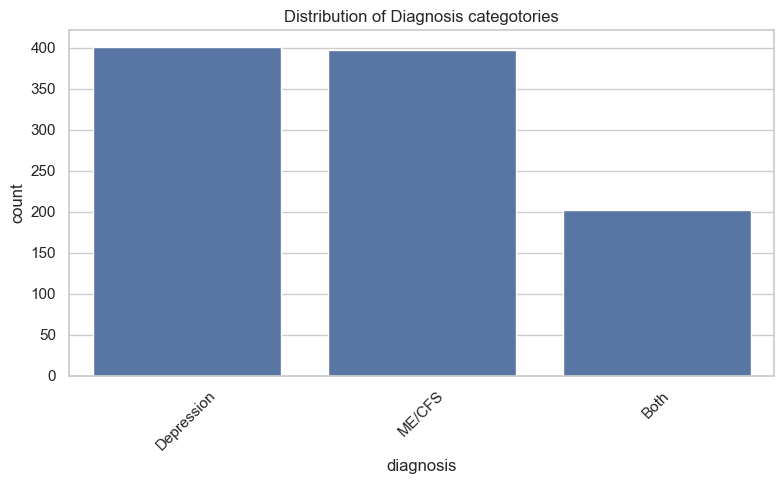


=== has_depression_dx value counts ===


has_depression_dx
False    599
True     401
Name: count, dtype: int64

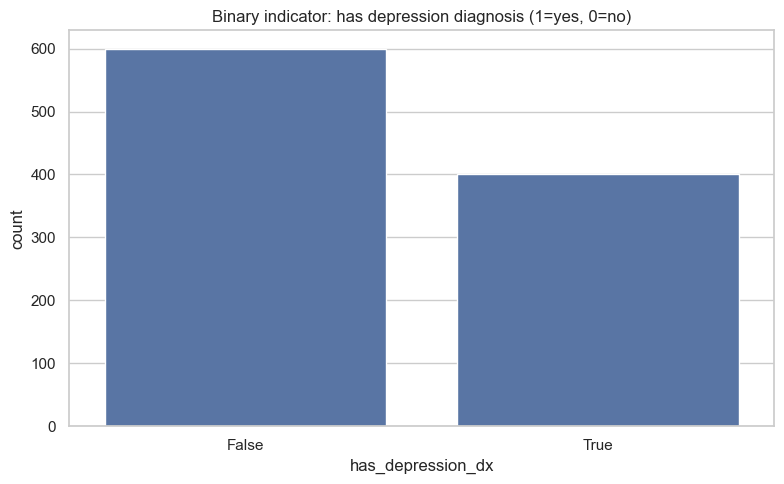

In [9]:
#=== 4. Target variable exploration ===


TARGET = "diagnosis"  


if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found in DataFrame.")

print("=== Target : diagnosis ===")
target_counts = df[TARGET].value_counts(dropna=False)
target_pct = df[TARGET].value_counts(normalize=True, dropna=False) * 100

diagnosis_summary = pd.DataFrame({
    "count": target_counts,
    "percentage": target_pct
}).sort_values("count", ascending=False)

display(diagnosis_summary)


# Bar plot of diagnosis distribution
fig, ax = plt.subplots()
sns.countplot(data=df, x=TARGET, order=diagnosis_summary.index, ax=ax)
ax.set_title("Distribution of Diagnosis categotories")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

# create a binary flag inicationg presence of depression in the diagnosis
df['has_depression_dx'] = df[TARGET].astype(str).str.contains('Depression', case=False)

print("\n=== has_depression_dx value counts ===")
display(df['has_depression_dx'].value_counts())


fig, ax = plt.subplots()
sns.countplot(data=df, x='has_depression_dx', ax=ax)
ax.set_title("Binary indicator: has depression diagnosis (1=yes, 0=no)")
plt.tight_layout()
plt.show()


#=== 4b. Key numeric predictor: depression_ph9_score ===


PHQ_COL = "depression_ph9_score"

if PHQ_COL in df.columns:
    print("\n=== PHQ-9 score Summary ===")
    display(df[PHQ_COL].describe())

    # Distribution
    fig, ax = plt.subplots()
    sns.histplot(df[PHQ_COL], kde=True, ax=ax)
    ax.set_title("Distribution of PHQ-9 Depression Scores")
    plt.tight_layout()
    plt.show()
    

    # Boxplot
    fig, ax = plt.subplots()
    sns.boxplot(x=df[PHQ_COL], ax=ax)
    ax.set_title("Boxplot of PHQ-9 Depression Scores")
    plt.tight_layout()
    plt.show()

    # Derive PHQ-9 severity categories
    def categorize_phq9(score:float) -> str:
        if pd.isna(score):
            return np.nan
        if score <= 4:
            return "Minimal"
        elif score <= 9:
            return "Mild"
        elif score <= 14:
            return "Moderate"
        elif score <= 19:
            return "Moderately Severe"
        else:
            return "Severe"
    
    df['phq9_severity'] = df[PHQ_COL].apply(categorize_phq9)

    print("\n=== PHQ-9 Severity Category Counts ===")
    display(df['phq9_severity'].value_counts(dropna=False))

    fig, ax = plt.subplots()
    sns.countplot(data=df, x='phq9_severity', order=["Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"], ax=ax)
    ax.set_title("PHQ-9 Severity Categories")
    ax.tick_params(axis="x", rotation=30)
    plt.tight_layout()
    plt.show()
    

    # PHQ-9 distribution by depression diagnosis
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=df, x=TARGET, y=PHQ_COL, ax=ax)
    ax.set_title("PHQ-9 Scores by Diagnosis Category")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


# Univariate distributions

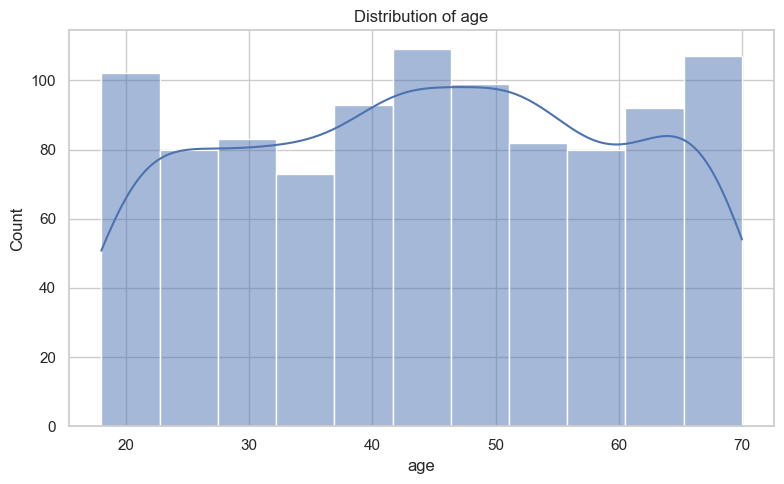

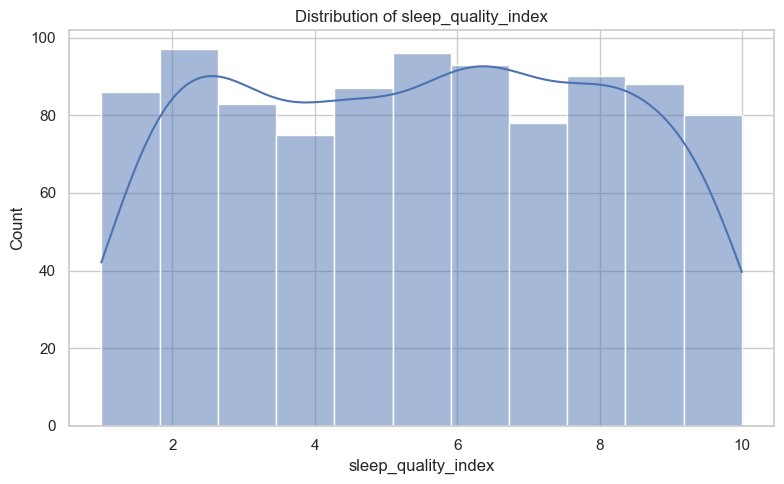

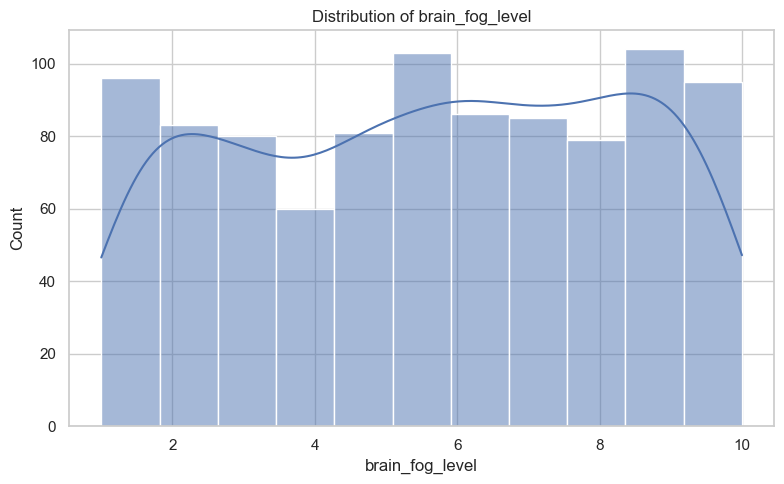

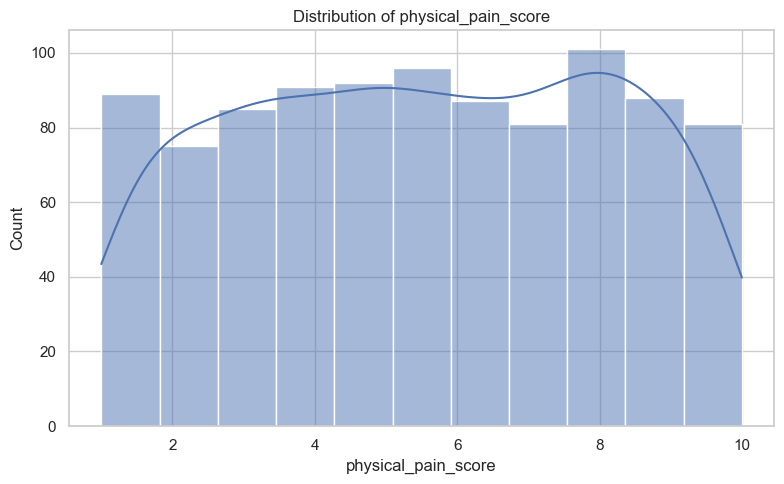

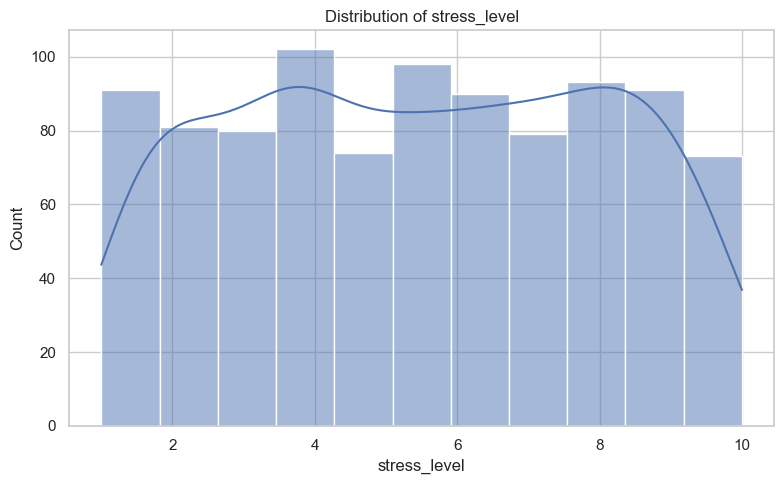

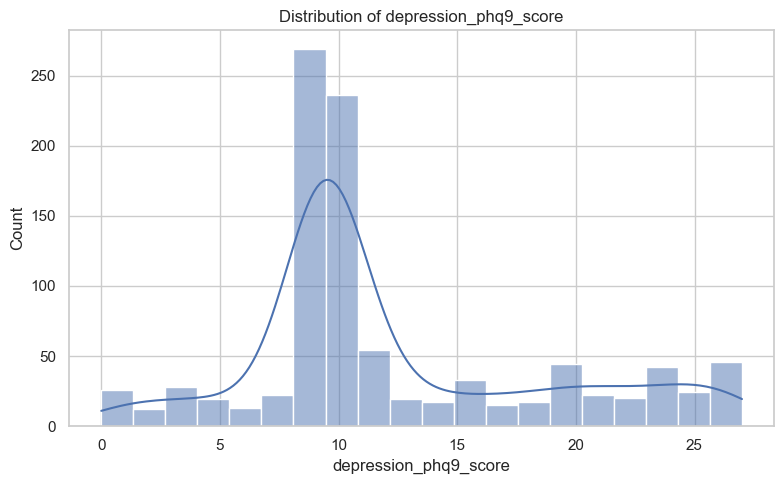

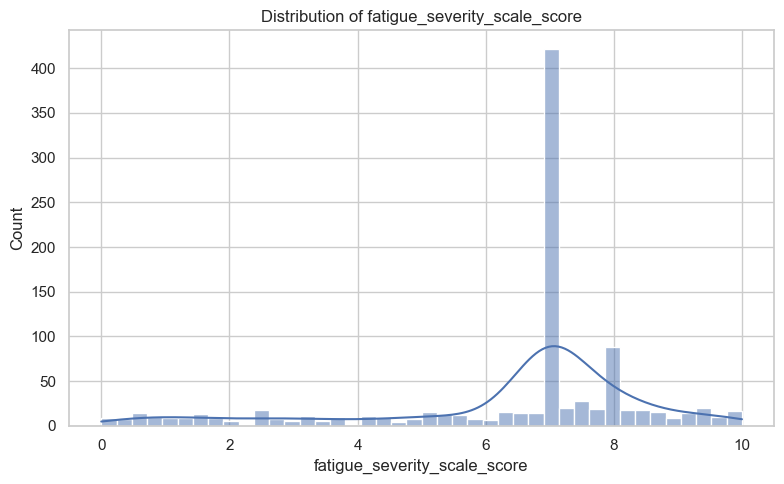

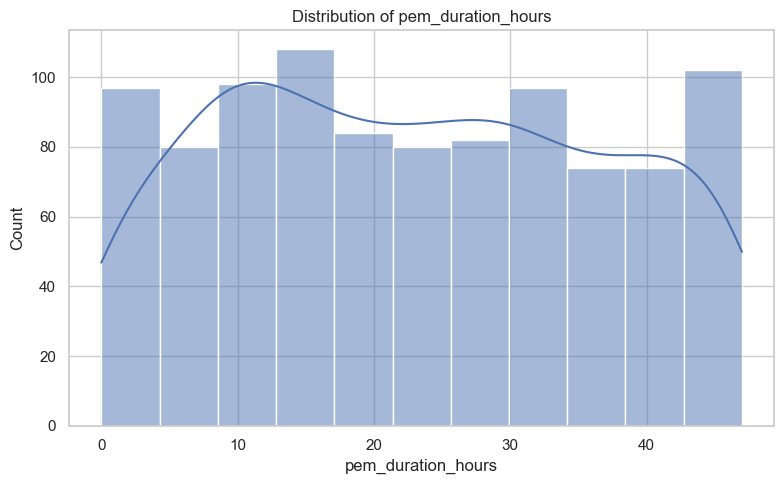

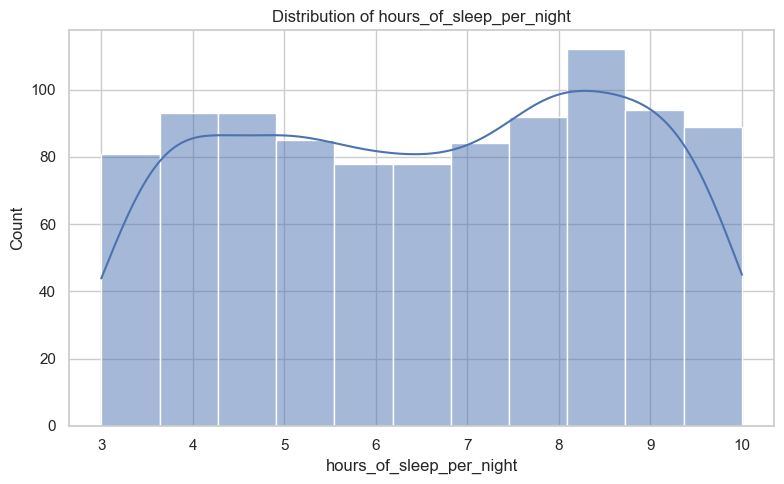

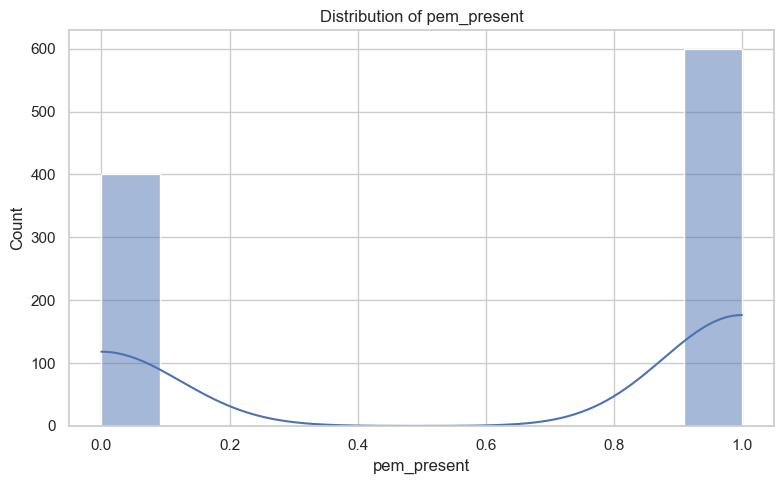

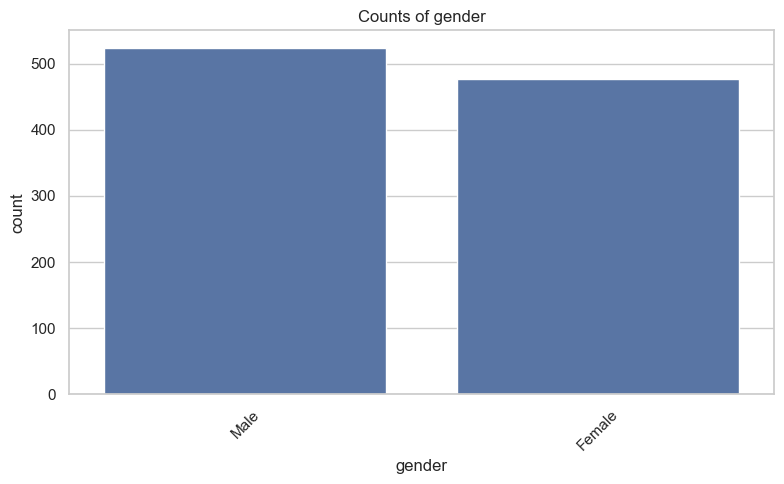

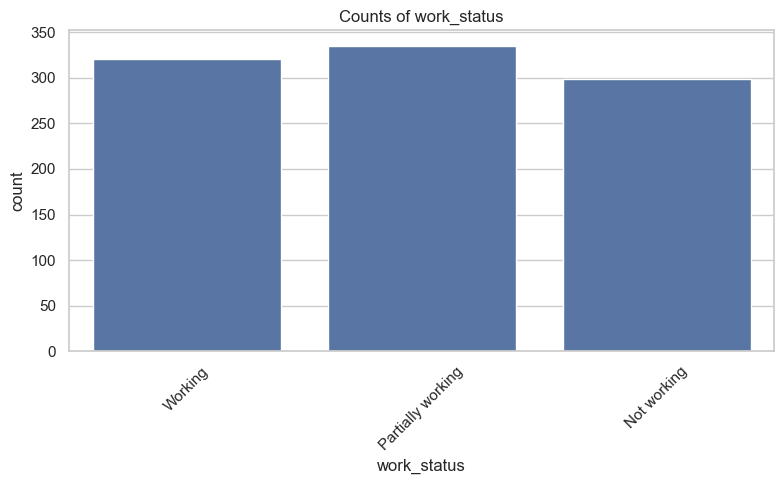

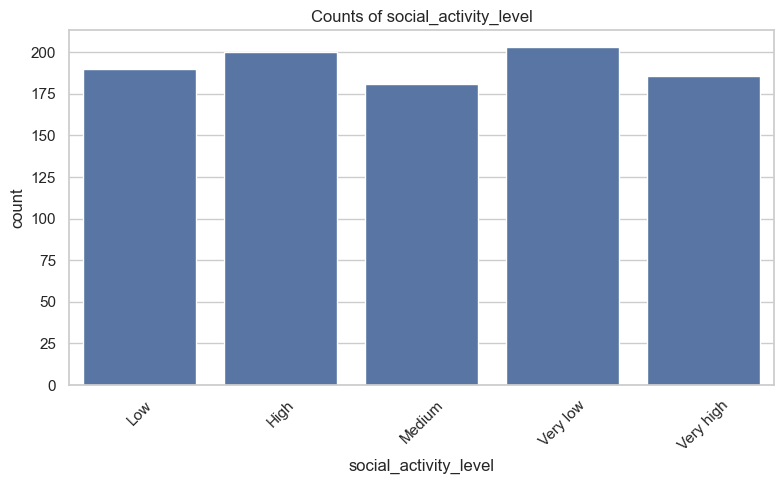

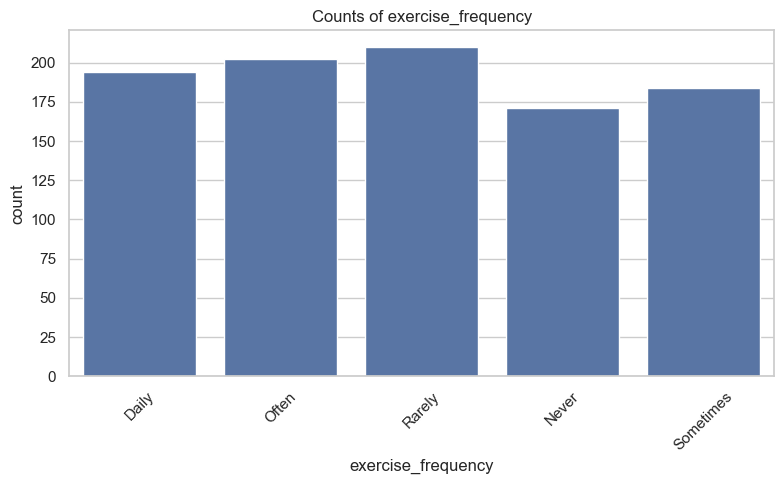

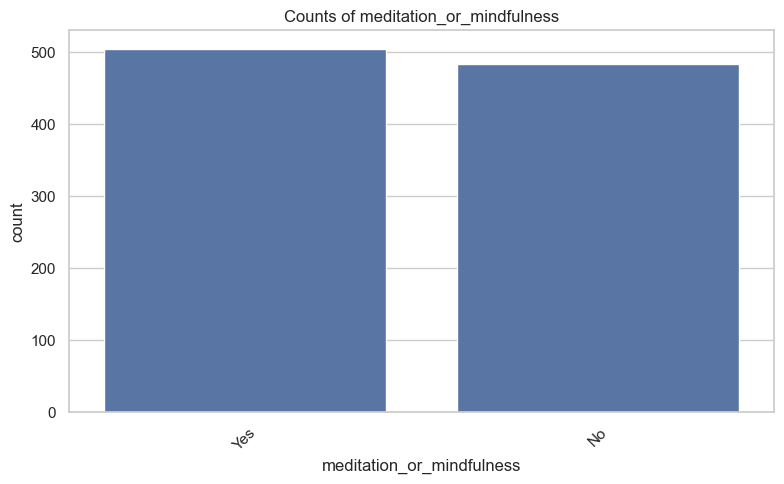

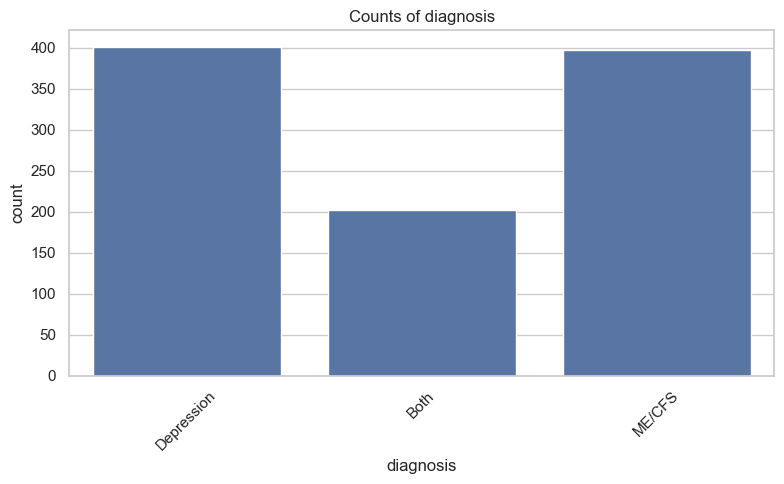

In [10]:
# === 5. Univariate distributions ===

# Numeric features (excluding the binary has_depression_dx)

numeric_without_flag = [
    col for col in numeric_columns 
    if col not in ["has_depression_dx"]
    ]

plot_numeric_distributions(df, numeric_without_flag)

# Categorical features
plot_categorical_counts(df, categorical_columns)

# Feature Engineering for EDA

In [11]:
# === 6. Feature engineering for EDA ===

from pandas.api.types import CategoricalDtype

# 1. Sleep deficit relative to 8 hours (positive values mean sleeping less than 8h)
if "hours_of_sleep_per_night" in df.columns:
    df["sleep_deficit"] = 8 - df["hours_of_sleep_per_night"]

# 2. Ordered categorical types
if "social_activity_level" in df.columns:
    social_order = ["Very low", "Low", "Medium", "High", "Very high"]
    social_type = CategoricalDtype(categories=social_order, ordered=True)
    df["social_activity_level"] = df["social_activity_level"].astype(social_type)

if "exercise_frequency" in df.columns:
    exercise_order = ["Never", "Rarely", "Sometimes", "Often", "Daily"]
    exercise_type = CategoricalDtype(categories=exercise_order, ordered=True)
    df["exercise_frequency"] = df["exercise_frequency"].astype(exercise_type)

df.head()


,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis,has_depression_dx,sleep_deficit
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression,True,0.3
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both,False,-0.4
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression,True,1.1
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression,True,0.5
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both,False,4.9


In [12]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Updated numeric columns:", numeric_cols)
print("Updated categorical columns:", categorical_cols)


Updated numeric columns: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present', 'sleep_deficit']
Updated categorical columns: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness', 'diagnosis']


# Correlations among numeric predictors 

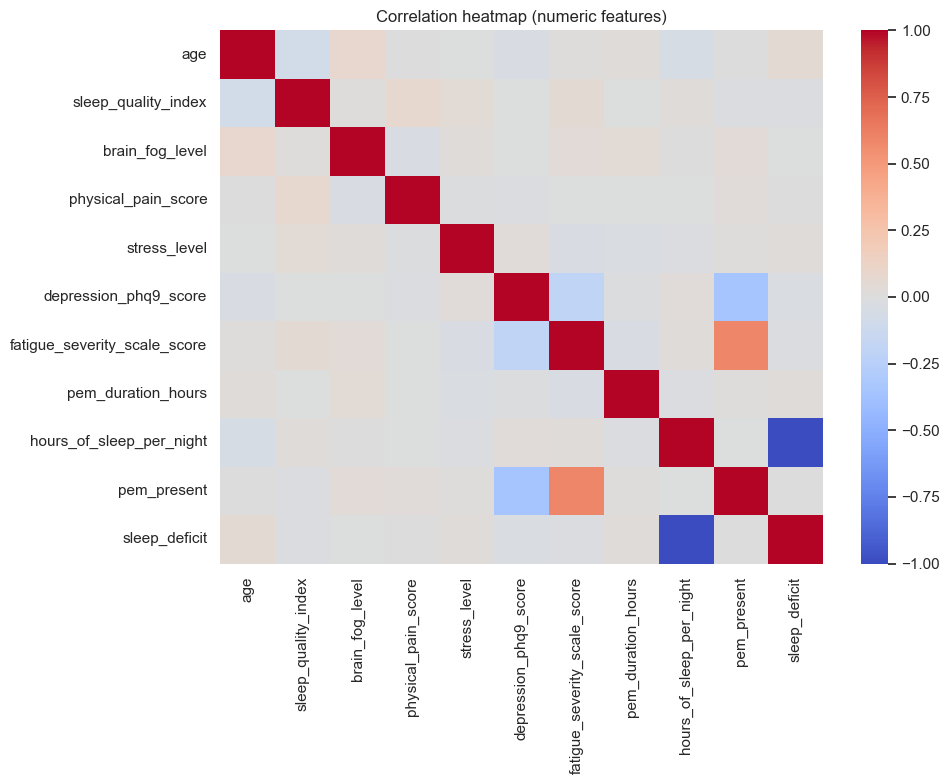

In [13]:
# === 7. Correlation analysis (numeric features only) ===

numeric_cols_for_corr = [
    col for col in numeric_cols
    if col not in []  # keep all numeric predictors; diagnosis is not numeric
]

corr_matrix = df[numeric_cols_for_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
ax.set_title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()


# Numeric features vs diagnosis


=== depression_phq9_score by diagnosis ===


,count,mean,std,median
diagnosis,,,,
Both,199,16.346734,5.975994,15.0
Depression,390,15.007692,5.919984,12.0
ME/CFS,389,7.437018,2.704381,9.0


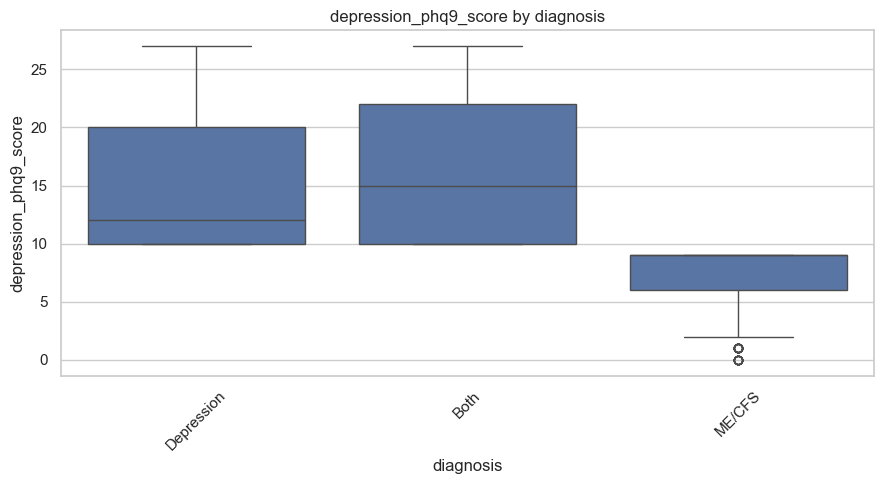


=== sleep_quality_index by diagnosis ===


,count,mean,std,median
diagnosis,,,,
ME/CFS,378,5.578836,2.651705,5.8
Depression,379,5.530079,2.477324,5.6
Both,196,5.137245,2.578569,5.2


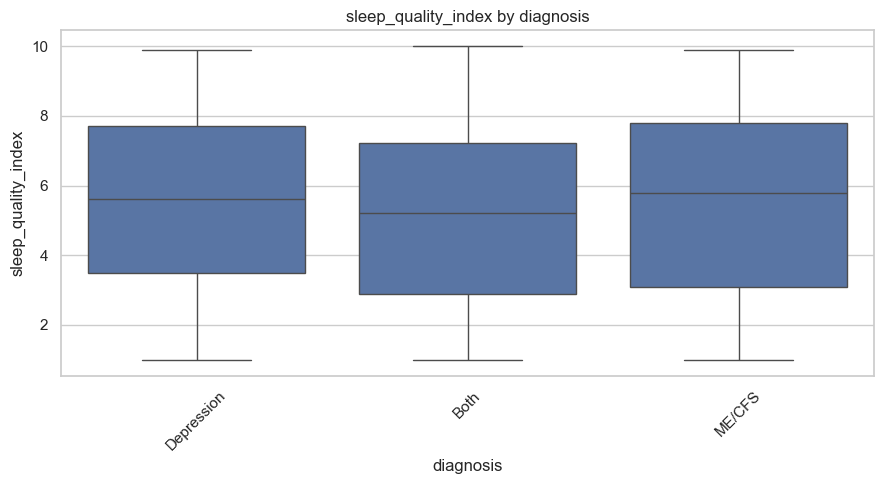


=== brain_fog_level by diagnosis ===


,count,mean,std,median
diagnosis,,,,
ME/CFS,380,5.740526,2.637289,5.9
Both,193,5.600000,2.661258,5.6
Depression,379,5.488654,2.656240,5.7


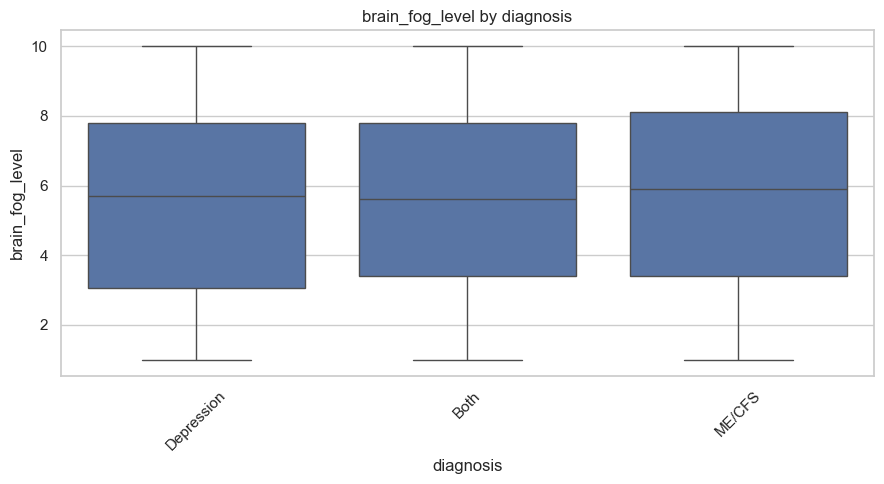


=== physical_pain_score by diagnosis ===


,count,mean,std,median
diagnosis,,,,
ME/CFS,383,5.589817,2.592231,5.6
Both,195,5.581538,2.564702,5.8
Depression,388,5.424742,2.542722,5.3


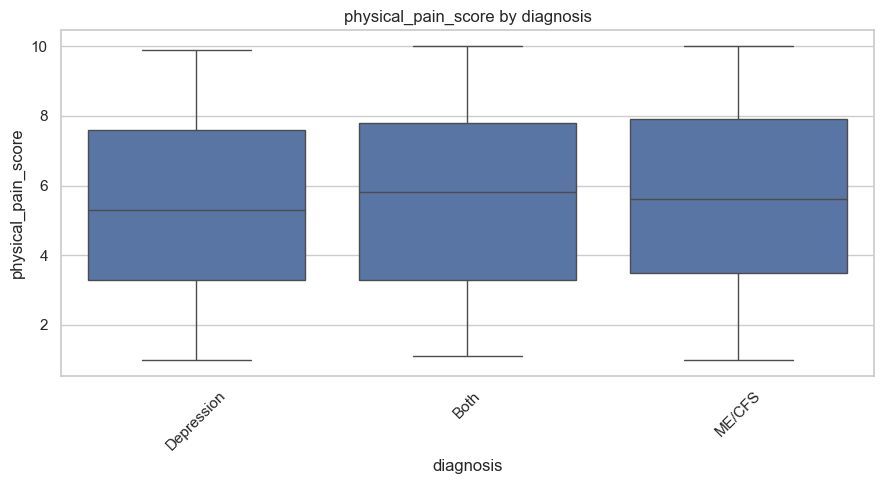


=== stress_level by diagnosis ===


,count,mean,std,median
diagnosis,,,,
Both,190,5.574211,2.541865,5.5
ME/CFS,375,5.433600,2.537819,5.5
Depression,387,5.427390,2.610903,5.4


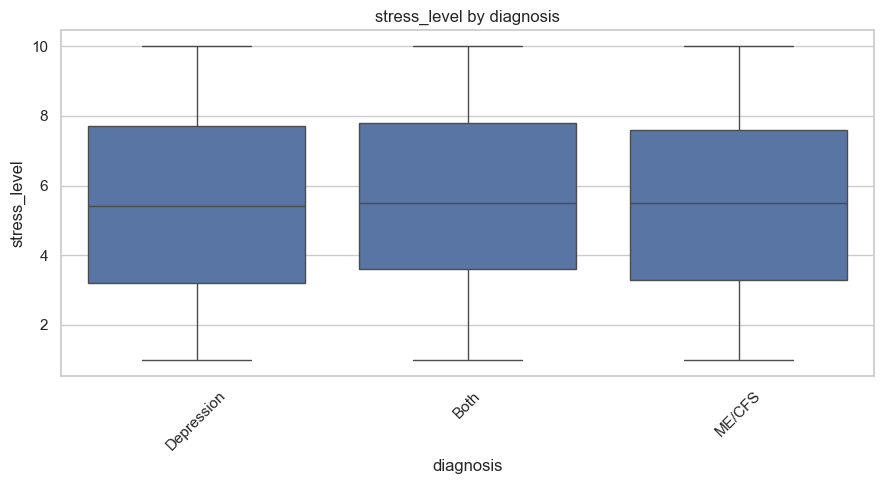


=== fatigue_severity_scale_score by diagnosis ===


,count,mean,std,median
diagnosis,,,,
ME/CFS,386,7.489896,0.873433,7.0
Both,200,7.448500,0.826932,7.0
Depression,393,4.813995,2.608235,5.3


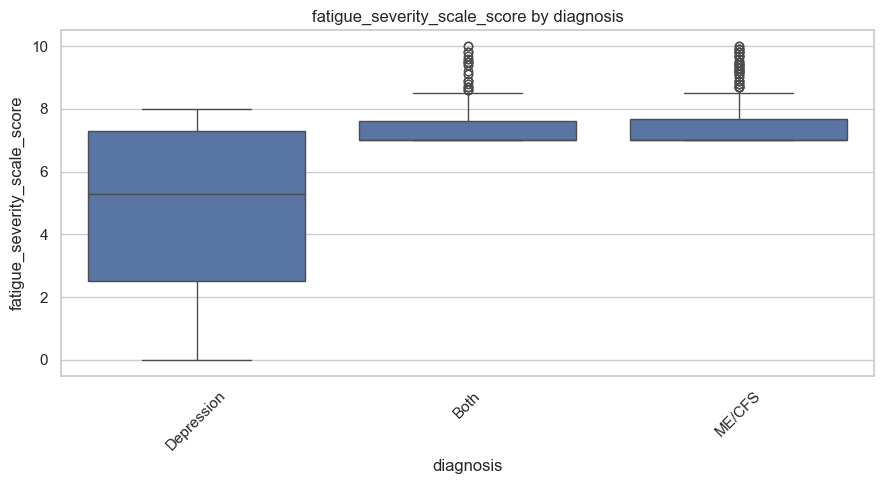


=== pem_duration_hours by diagnosis ===


,count,mean,std,median
diagnosis,,,,
ME/CFS,388,23.378866,13.837681,23.0
Both,201,22.965174,13.985842,23.0
Depression,387,22.904393,13.756907,22.0


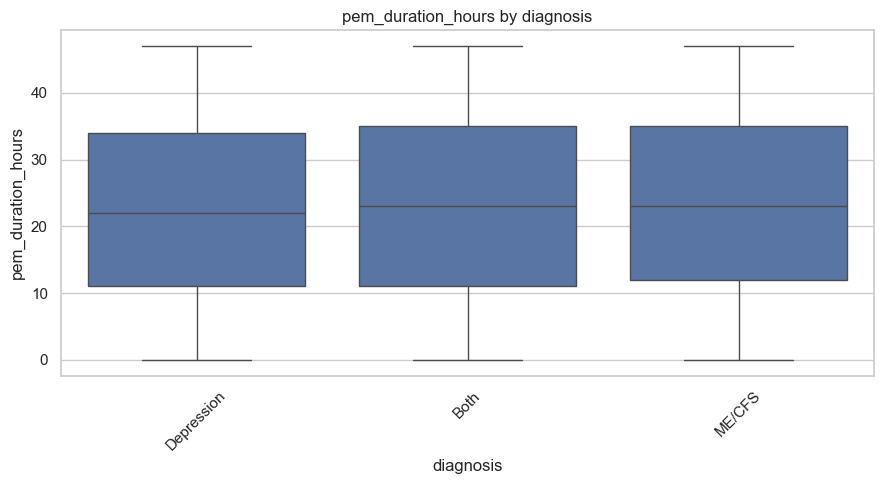


=== hours_of_sleep_per_night by diagnosis ===


,count,mean,std,median
diagnosis,,,,
Depression,393,6.587532,2.035996,6.7
ME/CFS,386,6.580311,2.052563,6.5
Both,200,6.522000,2.034555,6.6


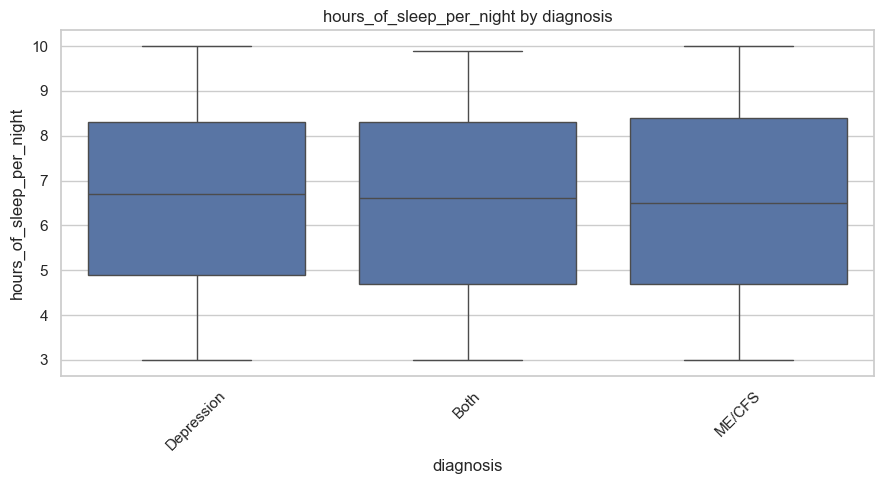


=== sleep_deficit by diagnosis ===


,count,mean,std,median
diagnosis,,,,
Both,200,1.478000,2.034555,1.4
ME/CFS,386,1.419689,2.052563,1.5
Depression,393,1.412468,2.035996,1.3


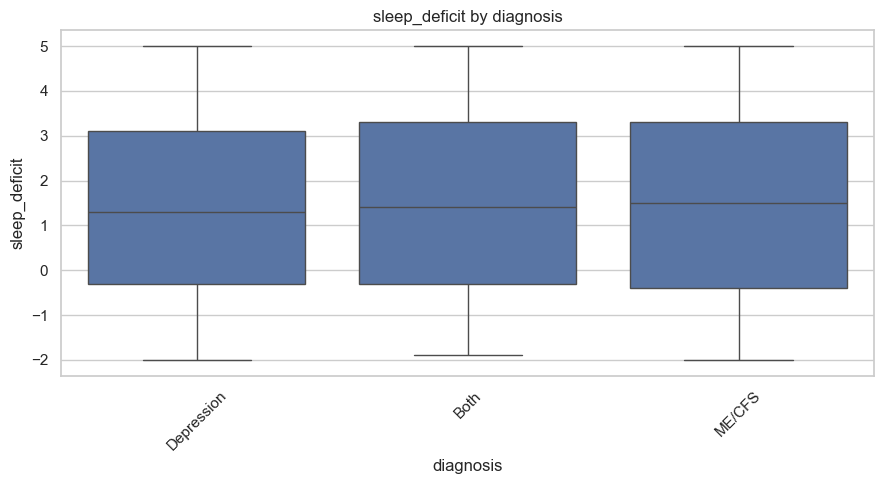


=== age by diagnosis ===


,count,mean,std,median
diagnosis,,,,
Both,202,44.688119,16.025997,44.5
ME/CFS,397,44.377834,15.176847,45.0
Depression,401,44.239401,15.137290,44.0


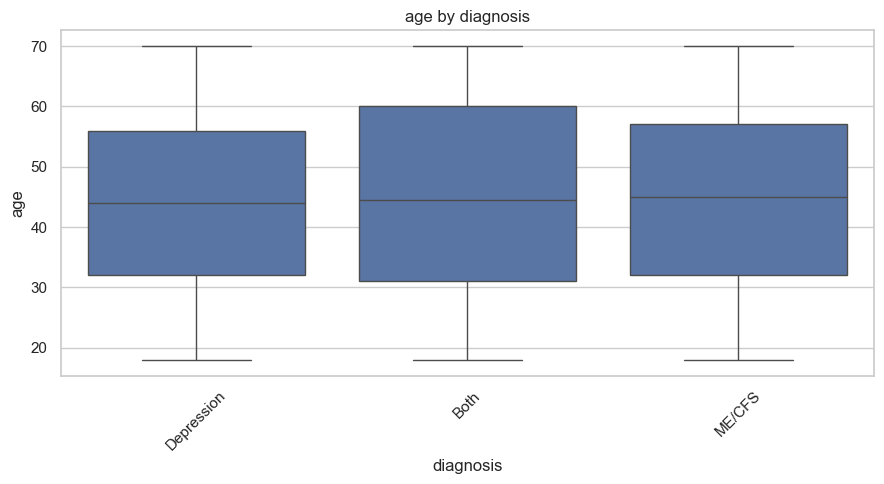

In [14]:
# === 8. Numeric features vs diagnosis ===

def summarize_numeric_by_category(df: pd.DataFrame, num_col: str, cat_col: str) -> pd.DataFrame:
    """
    Return summary stats of a numeric feature for each category of a categorical feature.
    """
    summary = (
        df.groupby(cat_col)[num_col]
        .agg(["count", "mean", "std", "median"])
        .sort_values("mean", ascending=False)
    )
    return summary

important_numeric_predictors = [
    col for col in [
        "depression_phq9_score",
        "sleep_quality_index",
        "brain_fog_level",
        "physical_pain_score",
        "stress_level",
        "fatigue_severity_scale_score",
        "pem_duration_hours",
        "hours_of_sleep_per_night",
        "sleep_deficit",
        "age"
    ]
    if col in df.columns
]

for col in important_numeric_predictors:
    print(f"\n=== {col} by {TARGET} ===")
    display(summarize_numeric_by_category(df, col, TARGET))
    
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.boxplot(data=df, x=TARGET, y=col, ax=ax)
    ax.set_title(f"{col} by {TARGET}")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


# Categorical features vs diagnosis


=== Crosstab: diagnosis vs gender (counts) ===


gender,Female,Male
diagnosis,,
Both,101,101
Depression,189,212
ME/CFS,186,211



=== Crosstab: diagnosis vs gender (row % ) ===


gender,Female,Male
diagnosis,,
Both,50.000000,50.000000
Depression,47.132170,52.867830
ME/CFS,46.851385,53.148615


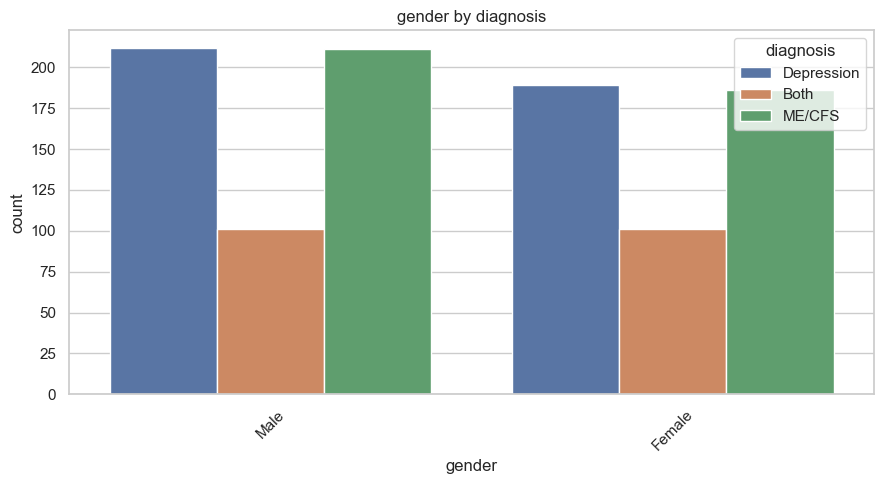


=== Crosstab: diagnosis vs work_status (counts) ===


work_status,Not working,Partially working,Working
diagnosis,,,
Both,71,64,57
Depression,122,139,119
ME/CFS,105,132,144



=== Crosstab: diagnosis vs work_status (row % ) ===


work_status,Not working,Partially working,Working
diagnosis,,,
Both,36.979167,33.333333,29.687500
Depression,32.105263,36.578947,31.315789
ME/CFS,27.559055,34.645669,37.795276


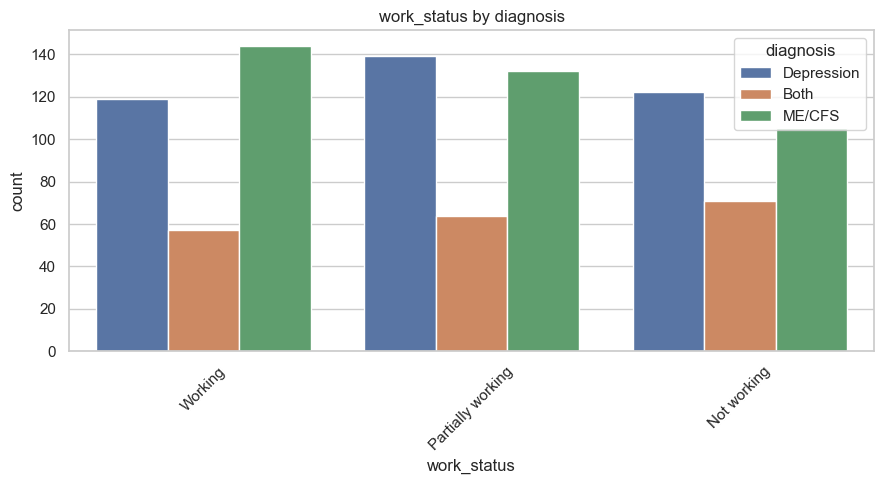


=== Crosstab: diagnosis vs social_activity_level (counts) ===


social_activity_level,Very low,Low,Medium,High,Very high
diagnosis,,,,,
Both,43,35,41,34,41
Depression,92,73,59,91,66
ME/CFS,68,82,81,75,79



=== Crosstab: diagnosis vs social_activity_level (row % ) ===


social_activity_level,Very low,Low,Medium,High,Very high
diagnosis,,,,,
Both,22.164948,18.041237,21.134021,17.525773,21.134021
Depression,24.146982,19.160105,15.485564,23.884514,17.322835
ME/CFS,17.662338,21.298701,21.038961,19.480519,20.519481


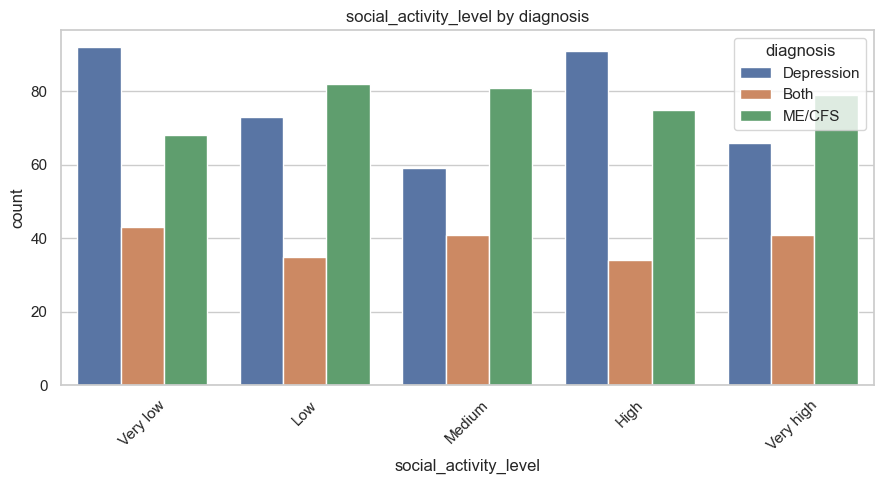


=== Crosstab: diagnosis vs exercise_frequency (counts) ===


exercise_frequency,Never,Rarely,Sometimes,Often,Daily
diagnosis,,,,,
Both,27,39,41,53,36
Depression,75,83,75,81,74
ME/CFS,69,88,68,68,84



=== Crosstab: diagnosis vs exercise_frequency (row % ) ===


exercise_frequency,Never,Rarely,Sometimes,Often,Daily
diagnosis,,,,,
Both,13.775510,19.897959,20.918367,27.040816,18.367347
Depression,19.329897,21.391753,19.329897,20.876289,19.072165
ME/CFS,18.302387,23.342175,18.037135,18.037135,22.281167


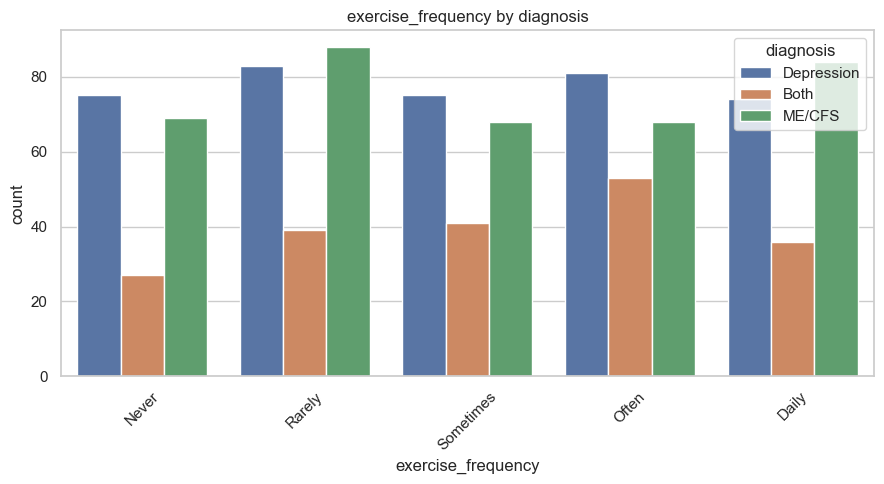


=== Crosstab: diagnosis vs meditation_or_mindfulness (counts) ===


meditation_or_mindfulness,No,Yes
diagnosis,,
Both,107,90
Depression,191,208
ME/CFS,186,207



=== Crosstab: diagnosis vs meditation_or_mindfulness (row % ) ===


meditation_or_mindfulness,No,Yes
diagnosis,,
Both,54.314721,45.685279
Depression,47.869674,52.130326
ME/CFS,47.328244,52.671756


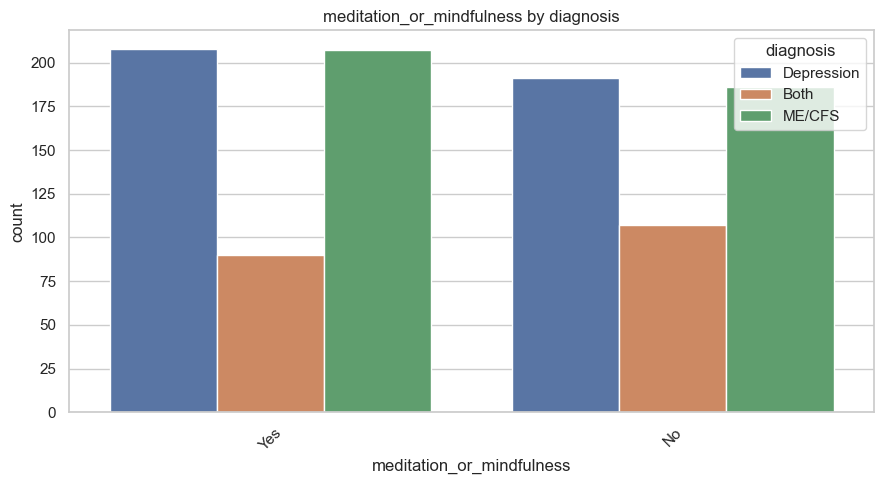


=== Crosstab: diagnosis vs pem_present (counts) ===


pem_present,0,1
diagnosis,,
Both,0,202
Depression,401,0
ME/CFS,0,397



=== Crosstab: diagnosis vs pem_present (row % ) ===


pem_present,0,1
diagnosis,,
Both,0.0,100.0
Depression,100.0,0.0
ME/CFS,0.0,100.0


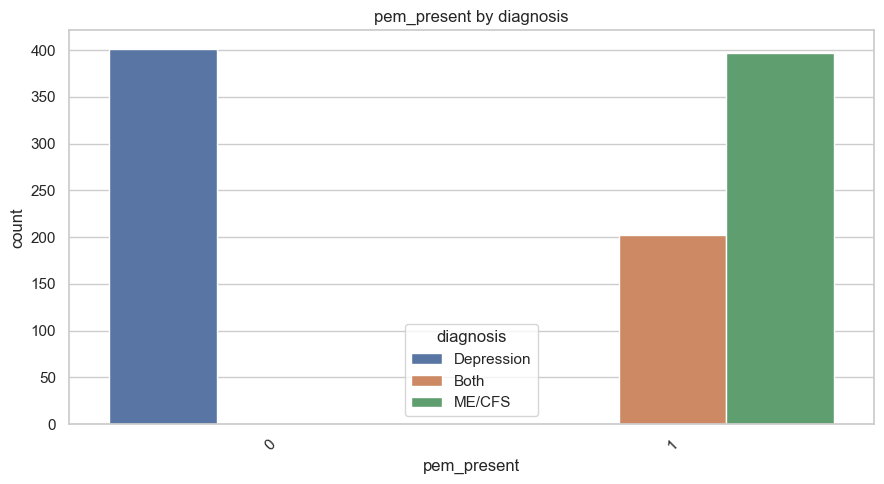

In [15]:
# === 9. Categorical features vs diagnosis ===

categoricals_for_target = [
    col for col in [
        "gender",
        "work_status",
        "social_activity_level",
        "exercise_frequency",
        "meditation_or_mindfulness",
        "pem_present",
        "phq9_severity"
    ]
    if col in df.columns
]

def crosstab_with_percent(df: pd.DataFrame, row_col: str, col_col: str) -> None:
    """
    Print crosstab counts and row percentages between two categorical columns.
    """
    print(f"\n=== Crosstab: {row_col} vs {col_col} (counts) ===")
    ctab = pd.crosstab(df[row_col], df[col_col])
    display(ctab)
    
    print(f"\n=== Crosstab: {row_col} vs {col_col} (row % ) ===")
    ctab_pct = pd.crosstab(df[row_col], df[col_col], normalize="index") * 100
    display(ctab_pct)

for col in categoricals_for_target:
    crosstab_with_percent(df, TARGET, col)
    
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.countplot(data=df, x=col, hue=TARGET, ax=ax)
    ax.set_title(f"{col} by {TARGET}")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


In [16]:
# === 10. Additional interaction analysis ===

if {"diagnosis", "pem_present"}.issubset(df.columns):
    crosstab_with_percent(df, "diagnosis", "pem_present")

if {"diagnosis", "phq9_severity"}.issubset(df.columns):
    crosstab_with_percent(df, "diagnosis", "phq9_severity")

if {"has_depression_dx", "phq9_severity"}.issubset(df.columns):
    crosstab_with_percent(df, "has_depression_dx", "phq9_severity")



=== Crosstab: diagnosis vs pem_present (counts) ===


pem_present,0,1
diagnosis,,
Both,0,202
Depression,401,0
ME/CFS,0,397



=== Crosstab: diagnosis vs pem_present (row % ) ===


pem_present,0,1
diagnosis,,
Both,0.0,100.0
Depression,100.0,0.0
ME/CFS,0.0,100.0
